In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
device

device(type='mps')

In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
raw_data_path = Path('../data/raw/brain-tumor-mri')

train_dataset = ImageFolder(raw_data_path / 'Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

val_dataset = ImageFolder(raw_data_path / 'Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [10]:

def visualize_batch(train_loader, train_dataset, 
                    mean=None, std=None, 
                    images_per_row=4, figsize=(15, 15)):
    """
    Visualizes a batch of images from a DataLoader.

    Parameters:
    - train_loader: DataLoader providing batches of images and labels.
    - train_dataset: Dataset object containing class names.
    - mean: List or array of channel-wise means for denormalization. Default is ImageNet mean.
    - std: List or array of channel-wise stds for denormalization. Default is ImageNet std.
    - images_per_row: Number of images to display per row in the grid.
    - figsize: Tuple for the figure size.
    """
    # Default normalization values for ImageNet
    if mean is None:
        mean = np.array([0.485, 0.456, 0.406])
    else:
        mean = np.array(mean)

    if std is None:
        std = np.array([0.229, 0.224, 0.225])
    else:
        std = np.array(std)

    # Load a batch
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    # Convert to NumPy and denormalize
    images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

    num_images = len(images)
    rows = int(np.ceil(num_images / images_per_row))
    fig, axes = plt.subplots(rows, images_per_row, figsize=figsize)

    # Flatten axes for easy iteration
    axes = axes.flat if isinstance(axes, np.ndarray) else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


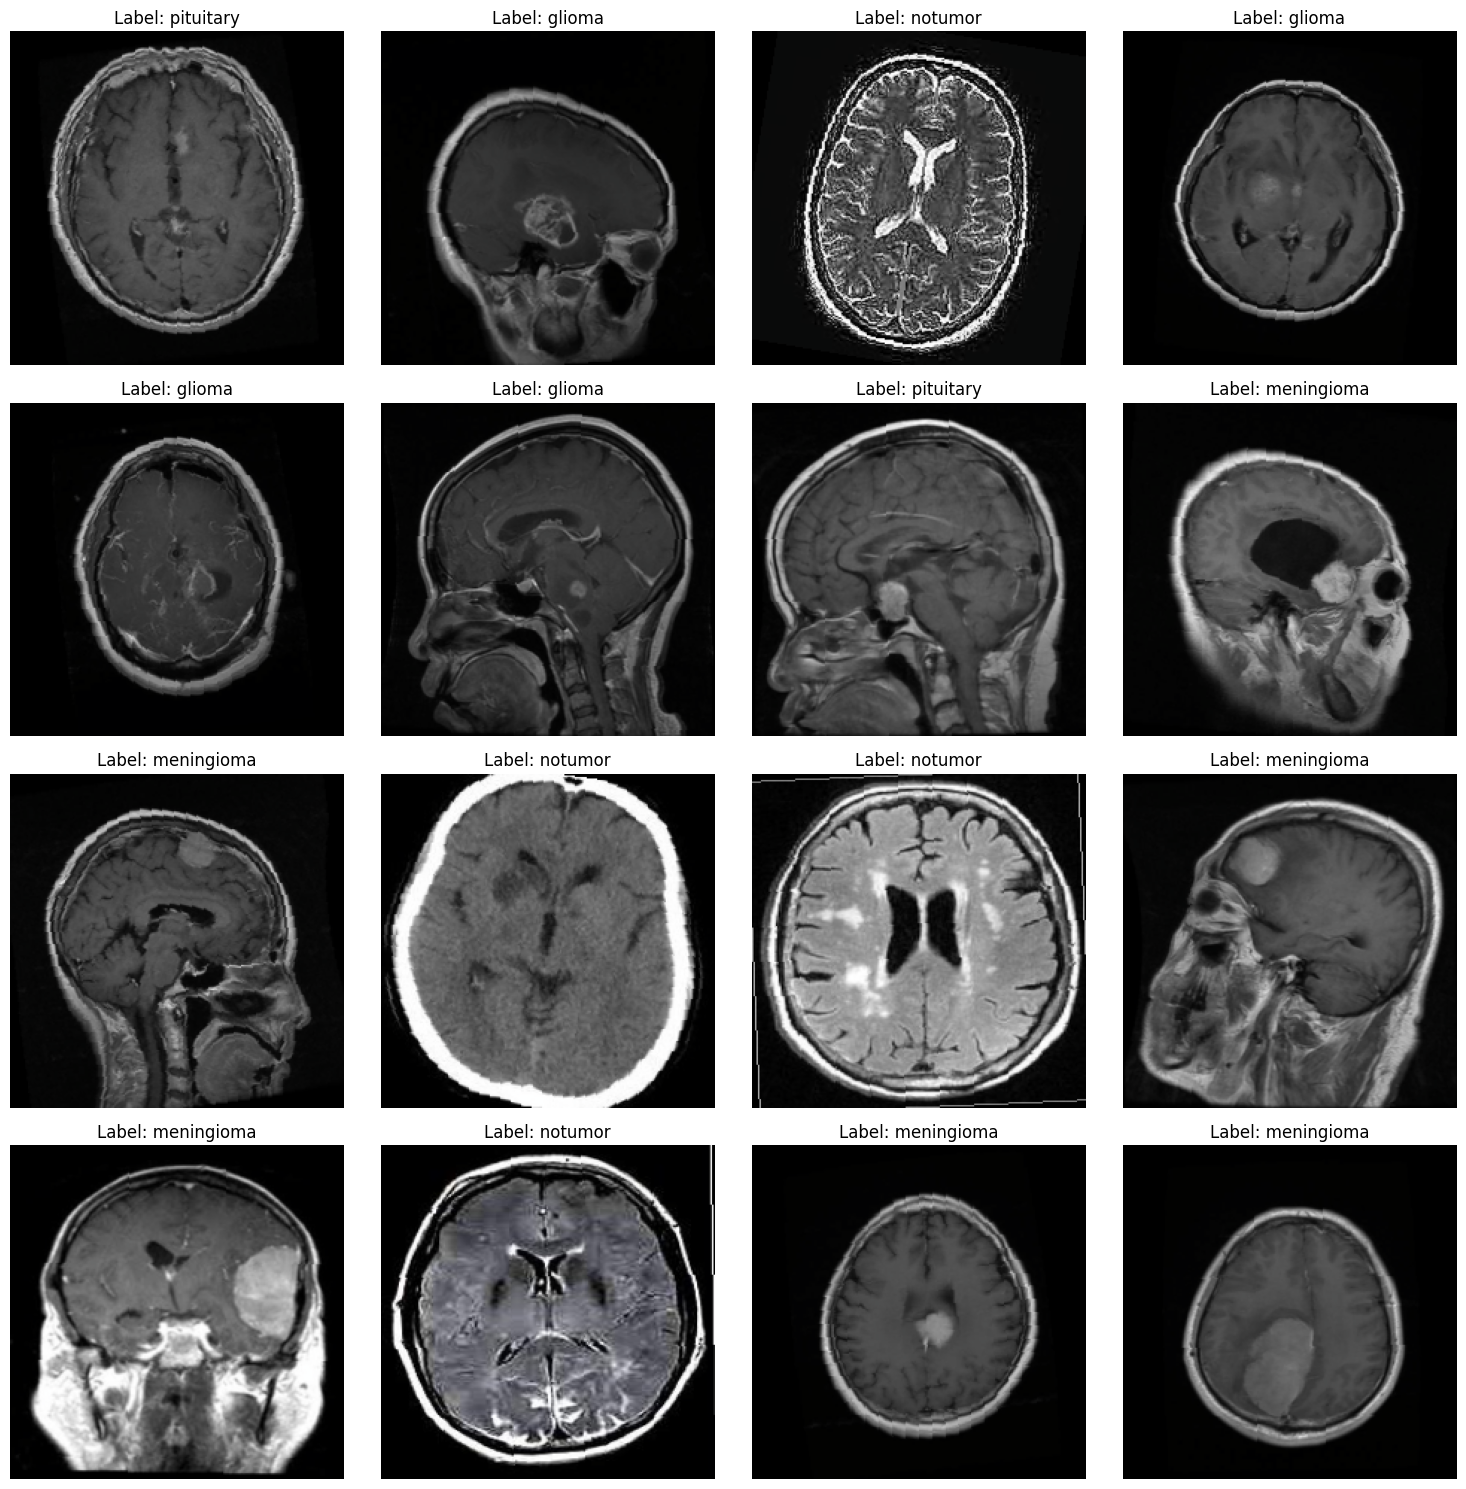

In [11]:
visualize_batch(train_loader, train_dataset)

In [34]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def build_tumor_classifier(num_classes, device=None):
    """
    Constructs the TumorClassifier model and moves it to the specified device.

    Parameters:
    - num_classes: int, number of output classes
    - device: torch.device or None. If None, defaults to CPU.

    Returns:
    - model: TumorClassifier instance on the specified device
    """
    model = TumorClassifier(num_classes)
    if device is not None:
        model.to(device)
    return model


In [35]:
model = build_tumor_classifier(num_classes=4, device=device)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os

# Replace with your actual dataset
# from your_dataset_module import train_dataset, val_dataset
# from your_model_module import TumorClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def log_confusion_matrix_plot(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    fig_path = "confusion_matrix.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.close()


def train_and_log(train_loader, val_loader, num_classes=4, num_epochs=20, lr=1e-3):
    mlflow.set_experiment("TumorClassifier BasicRun")

    with mlflow.start_run():
        model = TumorClassifier(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_acc = 0.0
        best_y_true, best_y_pred = [], []

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            model.eval()
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            val_acc = np.mean(np.array(y_true) == np.array(y_pred))
            mlflow.log_metric("val_accuracy_epoch_{}".format(epoch + 1), val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_y_true = y_true
                best_y_pred = y_pred
                torch.save(model.state_dict(), "best_model.pth")

        class_report = classification_report(best_y_true, best_y_pred, output_dict=True)
        cm = confusion_matrix(best_y_true, best_y_pred)

        mlflow.log_dict(class_report, "classification_report.json")
        mlflow.log_dict({"confusion_matrix": cm.tolist()}, "confusion_matrix.json")
        log_confusion_matrix_plot(cm, class_names=train_loader.dataset.classes)
        mlflow.log_metric("best_val_accuracy", best_val_acc)
        mlflow.log_artifact("best_model.pth")
        mlflow.pytorch.log_model(model, "model")

        print(f"Best Validation Accuracy: {best_val_acc:.4f}")


# ========== USAGE ==========

# Define data loaders
# Replace `train_dataset` and `val_dataset` with your actual dataset objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

train_and_log(train_loader, val_loader, num_classes=4, num_epochs=20, lr=1e-3)


2025/07/26 21:51:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 21:51:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/07/26 21:51:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Validation Accuracy: 0.9764


In [50]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.0):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import mlflow
import mlflow.pytorch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

  # Make sure this points to your actual model




In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import mlflow
import mlflow.pytorch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def log_confusion_matrix_plot(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    fig_path = "confusion_matrix.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.close()


def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return avg_loss, accuracy


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1


def objective(params, train_loader, val_loader, device):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)

        model = TumorClassifier(num_classes=4, dropout=params['dropout']).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        best_val_acc = 0.0
        best_model_state = None
        dummy_input = torch.randn(1, 3, 224, 224).to(device).cpu().numpy()  # Make sure dummy input is on device

        for epoch in range(10):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion, device)

            scheduler.step()

            # Convert all metrics to Python floats before logging
            mlflow.log_metrics({
                "train_loss": float(train_loss),
                "train_accuracy": float(train_acc),
                "val_loss": float(val_loss),
                "val_accuracy": float(val_acc),
                "val_precision": float(val_precision),
                "val_recall": float(val_recall),
                "val_f1": float(val_f1),
                "lr": float(scheduler.get_last_lr()[0])
            }, step=epoch)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        mlflow.pytorch.log_model(model, name="model", input_example=dummy_input)

        if best_model_state is not None:
            torch.save(best_model_state, "best_model.pth")
            mlflow.log_artifact("best_model.pth")

        # Return the loss as a plain Python float to hyperopt (note the negative sign for maximization)
        return {"loss": float(-best_val_acc), "status": STATUS_OK}




def tune_and_train(train_loader, val_loader, device, max_evals=25, tracking_uri="mlruns"):
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment("TumorClassifier Tuning")

    search_space = {
        'lr': hp.loguniform('lr', -5, -2),
        'dropout': hp.uniform('dropout', 0.0, 0.5)
    }

    trials = Trials()
    best = fmin(
        fn=lambda params: objective(params, train_loader, val_loader, device),
        space=search_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    # Get index of best trial
    best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
    best_val_accuracy = trials.trials[best_trial_idx]['result']['val_accuracy']

    print("Best hyperparameters:", best)
    print("Best validation accuracy:", best_val_accuracy)

    return best, best_val_accuracy

In [ ]:
best_params, best_acc = tune_and_train(train_loader, val_loader, device)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import io
import mlflow
import mlflow.pytorch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

class TumorClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.0):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def plot_metric(train_vals, val_vals, metric_name, filename):
    plt.figure(figsize=(8,5))
    plt.plot(train_vals, label=f"Train {metric_name}")
    plt.plot(val_vals, label=f"Val {metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()


def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            all_probs.append(probs.cpu())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    all_probs = torch.cat(all_probs).numpy()
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError:
        roc_auc = 0.0

    return float(avg_loss), float(accuracy), float(precision), float(recall), float(f1), float(roc_auc)


def train_and_log(train_loader, val_loader, device, num_classes=4, epochs=10, lr=1e-3, dropout=0.1):
    set_seed(42)
    
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.set_experiment("TumorClassifier_NoTuning")
    
    class_names = list(train_loader.dataset.class_to_idx.keys())
    

    with mlflow.start_run():
        model = TumorClassifier(num_classes=num_classes, dropout=dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        best_val_acc = 0.0
        best_model_state = None

        train_loss_hist, val_loss_hist = [], []
        train_acc_hist, val_acc_hist = [], []

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            train_loss = running_loss / len(train_loader.dataset)
            train_acc = accuracy_score(all_labels, all_preds)

            val_loss, val_acc, val_precision, val_recall, val_f1, val_roc_auc = evaluate(
                model, val_loader, criterion, device, num_classes
            )

            train_loss_hist.append(train_loss)
            val_loss_hist.append(val_loss)
            train_acc_hist.append(train_acc)
            val_acc_hist.append(val_acc)

            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": float(val_acc),
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1,
                "val_roc_auc": val_roc_auc,
                "learning_rate": scheduler.get_last_lr()[0]
            }, step=epoch)

            scheduler.step()

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

            print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        # Plot and log loss/accuracy history
        plot_metric(train_loss_hist, val_loss_hist, "Loss", "loss_history.png")
        plot_metric(train_acc_hist, val_acc_hist, "Accuracy", "accuracy_history.png")

        mlflow.log_artifact("loss_history.png")
        mlflow.log_artifact("accuracy_history.png")

        # Save and log best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            torch.save(best_model_state, "best_model.pth")
            mlflow.log_artifact("best_model.pth")

            example_input = torch.randn(1, 3, 224, 224).cpu()
            try:
                mlflow.pytorch.log_model(model, name="model", ) # input_example=example_input
            except Exception as e:
                print(f"Failed to log model: {e}")

        print(f"Best validation accuracy: {best_val_acc:.4f}")

In [24]:
train_and_log(train_loader, val_loader, device, num_classes=4, epochs=2, lr=1e-3, dropout=0.1)



Epoch 1/2 - Train loss: 0.7521, Train acc: 0.7642, Val loss: 0.4862, Val acc: 0.8116
Epoch 2/2 - Train loss: 0.3371, Train acc: 0.8738, Val loss: 0.4681, Val acc: 0.8429


2025/07/27 04:12:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/07/27 04:12:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best validation accuracy: 0.8429
